<a href="https://colab.research.google.com/github/ginchu/breast-cancer-image-segmentation/blob/main/augmentation_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook compares four model types trained on the augmented and non-augmented datasets. The goal is to see whether our augmentation procedure improved performance. The comparison will be in terms of Dice loss and IoU (Jaccard) accuracy on the full non-augmented dataset.


The model implementations used here are all provided in the popular [segmentation-models-pytorch library](https://github.com/qubvel/segmentation_models.pytorch).

All models were trained for 150 epochs, with an Adam optimizer having learning rate 0.003. The loss being minimized during training was Dice loss. The data used for training were different randomly selected subsets of 70% of the dataset (either augmented or non-augmented).

The following model types are being compared: FPN, MA-Net, PAN, and UNet++.

## Setup

In [2]:
# first time running: run below line to update matplotlib, then restart and run all
! pip install matplotlib==3.5.2

! pip install segmentation_models_pytorch

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load repo and data
print('Loading data...')
! git clone https://github.com/ginchu/breast-cancer-image-segmentation.git
print('Done!')

% cd breast-cancer-image-segmentation/

Loading data...
Cloning into 'breast-cancer-image-segmentation'...
remote: Enumerating objects: 704, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 704 (delta 22), reused 4 (delta 1), pack-reused 657
Receiving objects: 100% (704/704), 650.02 MiB | 27.16 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Done!
/content/breast-cancer-image-segmentation/breast-cancer-image-segmentation


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Subset
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

import segmentation_models_pytorch as smp
import data

## Load data

In [5]:
mydata = data.Dataset()
print(len(mydata))
print(mydata[1][0].shape)

generator = DataLoader(mydata, batch_size=8)

47
torch.Size([3, 512, 512])


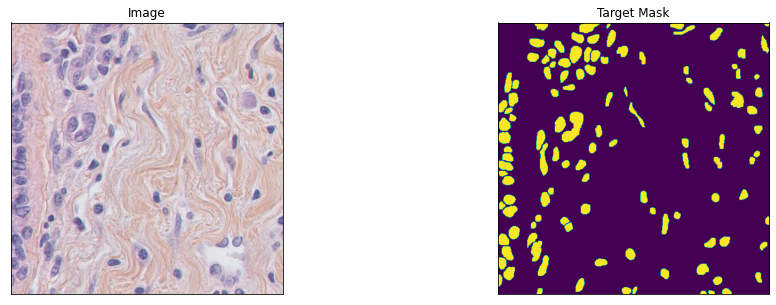

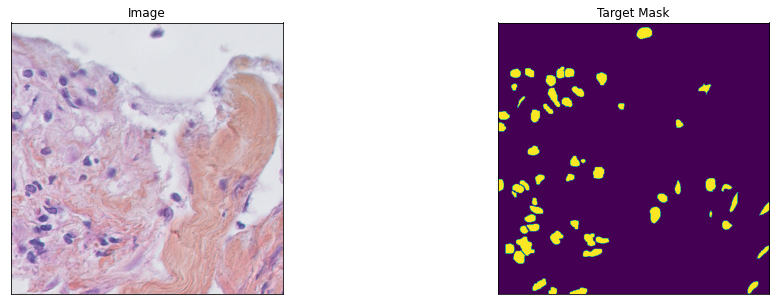

In [6]:
# helper function for data visualization
# from https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

img, mask = mydata[3]
visualize(
    image=img.permute(2,1,0),
    target_mask=mask.squeeze().permute(1,0)
)

img, mask = mydata[20]
visualize(
    image=img.permute(2,1,0),
    target_mask=mask.squeeze().permute(1,0)
)

## Load and test models

#### Record loss and performance for each model

In [7]:
loss = smp.utils.losses.DiceLoss()

metrics = [
           smp.utils.metrics.IoU(threshold=0.5)
]

In [8]:
logs = {}

weights_prefix = '/content/drive/MyDrive/best_weights_augVal/best_'

for m in ['FPN', 'MAnet', 'PAN', 'UNet++']:
  for a in ['noAug', 'withAug']:
    best_model = torch.load(weights_prefix+m+'_'+a+'.pth')

    test_epoch = smp.utils.train.ValidEpoch(
        model = best_model,
        loss = loss,
        metrics = metrics,
        device = 'cuda',
        verbose = True
    )

    print('\n'+m+'_'+a)

    logs[m+'_'+a] = test_epoch.run(generator)

    best_model.cpu()
    del best_model
    gc.collect()
    torch.cuda.empty_cache()


FPN_noAug
valid: 100%|██████████| 6/6 [00:02<00:00,  2.68it/s, dice_loss - 0.125, iou_score - 0.7831]

FPN_withAug
valid: 100%|██████████| 6/6 [00:01<00:00,  3.69it/s, dice_loss - 0.08216, iou_score - 0.8498]

MAnet_noAug
valid: 100%|██████████| 6/6 [00:01<00:00,  3.16it/s, dice_loss - 0.1039, iou_score - 0.8136]

MAnet_withAug
valid: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s, dice_loss - 0.1119, iou_score - 0.7994]

PAN_noAug
valid: 100%|██████████| 6/6 [00:01<00:00,  3.41it/s, dice_loss - 0.1188, iou_score - 0.7947]

PAN_withAug
valid: 100%|██████████| 6/6 [00:01<00:00,  3.44it/s, dice_loss - 0.09817, iou_score - 0.8258]

UNet++_noAug
valid: 100%|██████████| 6/6 [00:02<00:00,  2.18it/s, dice_loss - 0.08506, iou_score - 0.8447]

UNet++_withAug
valid: 100%|██████████| 6/6 [00:02<00:00,  2.19it/s, dice_loss - 0.06592, iou_score - 0.8772]


In [9]:
logs

{'FPN_noAug': {'dice_loss': 0.12496372063954671,
  'iou_score': 0.7831278940041859},
 'FPN_withAug': {'dice_loss': 0.08215800921122232,
  'iou_score': 0.8498444656531017},
 'MAnet_noAug': {'dice_loss': 0.10388272007306416,
  'iou_score': 0.8136333624521892},
 'MAnet_withAug': {'dice_loss': 0.11193179090817769,
  'iou_score': 0.799424409866333},
 'PAN_noAug': {'dice_loss': 0.11883402864138284,
  'iou_score': 0.7946520944436392},
 'PAN_withAug': {'dice_loss': 0.09816638628641765,
  'iou_score': 0.8257607916990917},
 'UNet++_noAug': {'dice_loss': 0.08505940437316895,
  'iou_score': 0.8446973661581675},
 'UNet++_withAug': {'dice_loss': 0.06592238942782085,
  'iou_score': 0.8772054811318716}}

#### Collect data for computing ROC curve, and compute ROC curve for each model

In [10]:
ROC_data = {}

for m in ['FPN', 'MAnet', 'PAN', 'UNet++']:
  for a in ['noAug', 'withAug']:
    print('working on {}_{}'.format(m, a))

    trues = []
    preds = []

    best_model = torch.load(weights_prefix+m+'_'+a+'.pth')
    best_model.eval()

    with torch.no_grad():
      for img, gt_mask in mydata:
        trues.append(gt_mask.numpy().flatten())

        pred = best_model(img.to('cuda').unsqueeze(0))
        preds.append(pred.cpu().numpy().flatten())

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)

    fpr, tpr, _ = roc_curve(trues, preds)

    ROC_data[m+'_'+a] = {'fpr': fpr,
                         'tpr': tpr,
                         'auc': auc(fpr, tpr)}

working on FPN_noAug
working on FPN_withAug
working on MAnet_noAug
working on MAnet_withAug
working on PAN_noAug
working on PAN_withAug
working on UNet++_noAug
working on UNet++_withAug


In [11]:
ROC_data

{'FPN_noAug': {'auc': 0.9787745098916107,
  'fpr': array([0.        , 0.002918  , 0.00322163, ..., 0.99979064, 0.99998412,
         1.        ]),
  'tpr': array([0.        , 0.58548152, 0.60521342, ..., 1.        , 1.        ,
         1.        ])},
 'FPN_withAug': {'auc': 0.9907818196816697,
  'fpr': array([0.        , 0.00375487, 0.0040442 , ..., 0.97590523, 0.97590551,
         1.        ]),
  'tpr': array([0.        , 0.79240174, 0.80295699, ..., 0.99996269, 0.99996269,
         1.        ])},
 'MAnet_noAug': {'auc': 0.9691303472923345,
  'fpr': array([0.        , 0.00539945, 0.00584297, ..., 0.99999099, 0.99999099,
         1.        ]),
  'tpr': array([0.        , 0.73006289, 0.75014474, ..., 0.99999936, 1.        ,
         1.        ])},
 'MAnet_withAug': {'auc': 0.9478761591012097,
  'fpr': array([0.        , 0.01095801, 0.01129313, ..., 0.99987117, 0.99987117,
         1.        ]),
  'tpr': array([0.        , 0.84433974, 0.84786052, ..., 0.99999936, 1.        ,
         1. 

#### Plot ROC curves that indicate AUC in legend

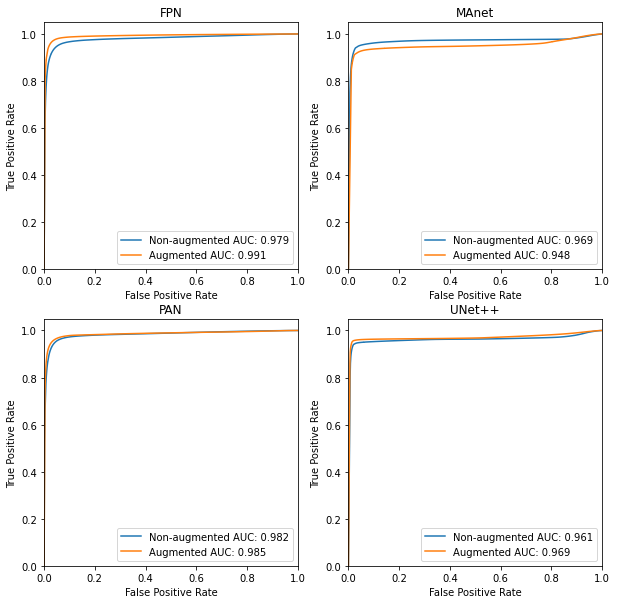

In [15]:
i = 1
plt.figure(figsize=(10,10))

for m in ['FPN', 'MAnet', 'PAN', 'UNet++']:
  plt.subplot(2,2,i)
  for a in ['noAug', 'withAug']:
    if a == 'noAug':
      plt.plot(ROC_data[m+'_'+a]['fpr'],
               ROC_data[m+'_'+a]['tpr'],
               label = 'Non-augmented AUC: {}'.format(round(ROC_data[m+'_'+a]['auc'],3)))
    else:
      plt.plot(ROC_data[m+'_'+a]['fpr'],
          ROC_data[m+'_'+a]['tpr'],
          label = 'Augmented AUC: {}'.format(round(ROC_data[m+'_'+a]['auc'],3)))

  i += 1

  plt.xlim([0, 1])
  plt.ylim([0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(m)
  plt.legend(loc='lower right')

#plt.savefig('ROC_curves.png', dpi=500, bbox_inches='tight')
plt.show()

#### Plot bar charts comparing performance of models
In terms of IoU/Jaccard score (higher is better) and Dice loss (lower is better)

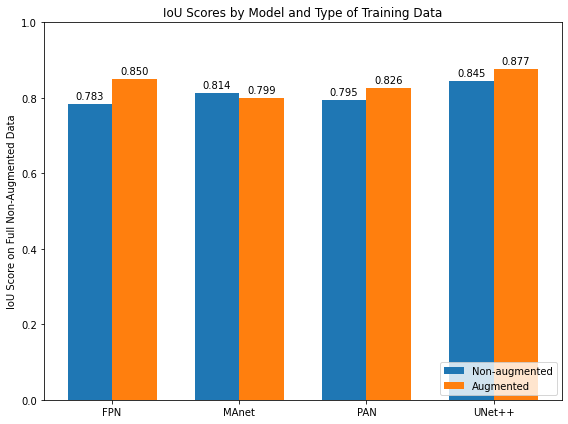

In [16]:
# adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

labels = ['FPN', 'MAnet', 'PAN', 'UNet++']
nonaug = [logs[i+'_noAug']['iou_score'] for i in labels]
withaug = [logs[i+'_withAug']['iou_score'] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, nonaug, width, label='Non-augmented')
rects2 = ax.bar(x + width/2, withaug, width, label='Augmented')

ax.set_ylabel('IoU Score on Full Non-Augmented Data')
ax.set_ylim(top = 1)
ax.set_title('IoU Scores by Model and Type of Training Data')
ax.set_xticks(x, labels)
ax.legend(loc = 'lower right')

ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()

#plt.savefig('IoU_bars.png', dpi=500, bbox_inches='tight')
plt.show()

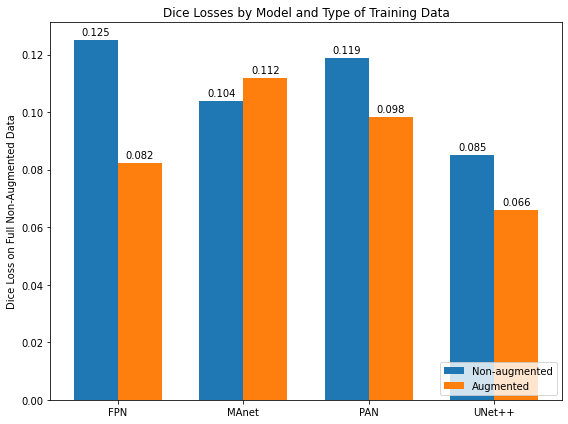

In [17]:
labels = ['FPN', 'MAnet', 'PAN', 'UNet++']
nonaug = [logs[i+'_noAug']['dice_loss'] for i in labels]
withaug = [logs[i+'_withAug']['dice_loss'] for i in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, nonaug, width, label='Non-augmented')
rects2 = ax.bar(x + width/2, withaug, width, label='Augmented')

ax.set_ylabel('Dice Loss on Full Non-Augmented Data')
ax.set_title('Dice Losses by Model and Type of Training Data')
ax.set_xticks(x, labels)
ax.legend(loc = 'lower right')

ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()

#plt.savefig('dice_bars.png', dpi=500, bbox_inches='tight')
plt.show()